## Домашнее задание №1


#### Тема: Языковое моделирование и определение языка.


**Выдана**:   14 сентября 2017

**Дедлайн**:   <font color='red'>9:00 утра 28 сентября 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 3)

#### Правила:

Результат выполнения задания $-$ отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев $-$ тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 3). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение семинаристов в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе Вам предстоит реализовать n-грамную языковую модель с несколькими видами сглаживания:
- Add-one smoothing
- Stupid backoff
- Interpolation smoothing
- Kneser-Ney smoothing

Вы обучите ее на готовых корпусах, оцените качество и проведете ряд экспериментов. Во второй части задания Вы примените реализованную модель (но с буквенными n-граммами) к задаче распознавания языка. 


# Языковые модели

Цель языкового моделирования заключается в том, чтобы присвоить некоторые вероятности предложениям. Задача состоит в подсчете вероятности $P(W) = P(w_1, \dots, w_n)$ или $P(w_n \mid w_1, \dots, w_{n-1})$. Модель, умеющая вычислять хотя бы одну из этих двух вероятностей, называется **языковой моделью** (LM от Language Model).

Согласно **цепному правилу** (chain rule):

$$P(X_1, \dots, X_n) = P(X_1)P(X_2 \mid X_1)\dots P(X_n \mid X_1, \dots, X_{n-1}).$$ 

Также мы знаем, что

$$
    P(X_n \mid X_1, \dots, X_{n-1}) = \frac{P(X_1, \dots, X_n)}{P(X_1, \dots, X_{n-1})},
$$

следовательно, для того чтобы оценить $P(X_n \mid X_1, \dots, X_{n-1})$ нужно посчитать $P(X_1, \dots, X_n)$ и $P(X_1, \dots, X_{n-1})$. Но эти вероятности будут чрезвычайно малы, если мы возьмем большое $n$, так множество предложений из $n$ слов растет экспоненциально. Для упрощения применим **марковское предположение**: 

$$P(X_n \mid X_1, \dots, X_{n-1}) = P(X_n \mid X_{n - k + 1}, \dots, X_{n-1})$$

для некоторого фиксированного (небольшого) $k$. Это предположение говорит о том, что $X_{n}$ не зависит от $X_{1}, \dots, X_{n - k}$, то есть на следующее слово влияет лишь контекст из предыдущих $k - 1$ слова. Таким образом, мы получаем финальную вероятность:

$$
    P(w_1, \dots, w_n) = \prod_i P(w_i \mid w_{i-k+1}, \dots, w_{i - 1}).
$$

Далее для краткости будем обозначать $w_{i-k}^i := w_{i-k}, \dots, w_{i}$.

## Хранилище n-грам

Для начала выполним вспомогательную работу. Следуйте комментариям, чтобы написать NGramStorage с удобным интерфейсом.

In [18]:
import re
import math
import random
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [19]:
class NGramStorage:
    """Storage for ngrams' frequencies.
    
    Args:
        sents (list[list[str]]): List of sentences from which ngram
            frequencies are extracted.
        max_n (int): Upper bound of the length of ngrams.
            For instance if max_n = 2, then storage will store
            0, 1, 2-grams.
            
    Attributes:
        max_n (Readonly(int)): Upper bound of the length of ngrams.
    """
        
    def __init__(self, sents=[], max_n=0):
        self.__max_n = max_n
        self.__ngrams = {i: Counter() for i in range(self.__max_n + 1)}
        self.__v = 0
        self.__different_pairs = 0
        # self._ngrams[K] should have the following interface:
        # self._ngrams[K][(w_1, ..., w_K)] = number of times w_1, ..., w_K occured in words
        # self._ngrams[0][()] = number of all words
        # self.__v = number of different words
        
        ### YOUR CODE HERE
        
        for sent in sents:
            self.__ngrams[0][()] = self.__ngrams[0][()] + len(sent)
            
        different_words = set()
        for sent in sents:
            for word in sent:
                different_words.add(word)
        self.__v = len(different_words)
        self.__diffent_words = different_words
        
        different_pairs = set()
        for sent in sents:
            for i in range(len(sent) - 1):
                different_pairs.add((sent[i], sent[i + 1]))
        self.__different_pairs = len(different_pairs)
        
        for i in range(1, self.__max_n + 1):
            i_gramms = []
            for sent in sents:
                for start in range(len(sent) - i + 1):
                    i_gramma = []
                    for index in range(start, start + i):
                        i_gramma.append(sent[index])
                    i_gramms.append(tuple(i_gramma))
            self.__ngrams[i] = Counter(i_gramms)

        ### END YOUR CODE
        
    def add_unk_token(self):
        """Add UNK token to 1-grams."""
        # In order to avoid zero probabilites 
        if self.__max_n == 0 or 'UNK' in self.__ngrams[1]:
            return
        self.__ngrams[0][()] += 1
        self.__ngrams[1][('UNK', )] = 1
        
    @property
    def max_n(self):
        """Get max_n"""
        return self.__max_n
        
    def __getitem__(self, k):
        """Get dictionary of k-gram frequencies.
        
        Args:
            k (int): length of returning ngrams' frequencies.
            
        Returns:
            Dictionary (in fact Counter) of k-gram frequencies.
        """
        # Cheking the input
        if not isinstance(k, int):
            raise TypeError('k (length of ngrams) must be an integer!')
        if k > self.__max_n:
            raise ValueError('k (length of ngrams) must be less or equal to the maximal length!')
        return self.__ngrams[k]
    
    def __call__(self, ngram):
        """Return frequency of a given ngram.
        
        Args:
            ngram (tuple): ngram for which frequency should be computed.
            
        Returns:
            Frequency (int) of a given ngram.
        """
        # Cheking the input
        if not isinstance(ngram, tuple):
            raise TypeError('ngram must be a tuple!')
        if len(ngram) > self.__max_n:
            print("ngram length =", len(ngram), "max_n =", self.__max_n)
            raise ValueError('length of ngram must be less or equal to the maximal length!')
        if len(ngram) == 1 and ngram not in self.__ngrams[1]:
            return self.__ngrams[1][('UNK', )]
        return self.__ngrams[len(ngram)][ngram]
    
    def get_v(self):
        return self.__v
    
    def get_n_plus(self, context):
        n_plus = 0
        for word in self.__diffent_words:
            if self(context + (word,)) > 0:
                n_plus = n_plus + 1
        return n_plus
    
    def get_c_sum(self, context):
        c_sum = 0
        for word in self.__diffent_words:
            c_sum = c_sum + self(context + (word, ))
        return c_sum
    
    def get_different_words(self):
        return self.__diffent_words
    
    def get_different_pairs(self):
        return self.__different_pairs

Want to check new storage

In [20]:
n_gram_storage = NGramStorage([["a", "b", "c"], ["b", "c", "b", "d"]], 4)
for i in range(5):
    print(n_gram_storage[i])
print(n_gram_storage(('b', 'c')))
print("different words = ",n_gram_storage.get_v())
print(n_gram_storage.get_n_plus(("b",)))
print(n_gram_storage.get_different_words())

Counter({(): 7})
Counter({('b',): 3, ('c',): 2, ('a',): 1, ('d',): 1})
Counter({('b', 'c'): 2, ('c', 'b'): 1, ('b', 'd'): 1, ('a', 'b'): 1})
Counter({('b', 'c', 'b'): 1, ('a', 'b', 'c'): 1, ('c', 'b', 'd'): 1})
Counter({('b', 'c', 'b', 'd'): 1})
2
different words =  4
2
{'b', 'a', 'd', 'c'}


## Оценка качества

Скачайте brown корпус, обучите модель и протестируйте на нескольких примерах последовательностей.

In [21]:
import nltk
# Uncomment next row and download brown corpus
# nltk.download()

In [22]:
from nltk.corpus import brown

In [23]:
all_sents = list(brown.sents())
random.shuffle(all_sents)
print('Number of all sentences = {}'.format(len(all_sents)))
train_sents = all_sents[:int(0.8 * len(all_sents))]
test_sents = all_sents[int(0.8 * len(all_sents)):]
print('Number of train sentences = {}'.format(len(train_sents)))
print('Number of test sentences = {}'.format(len(test_sents)))

Number of all sentences = 57340
Number of train sentences = 45872
Number of test sentences = 11468


In [24]:
# Create storage of 0, 1, 2, 3-grams
storage = NGramStorage(train_sents, 3)

In [25]:
# It's time to test your code
print(storage(('to', 'be')))
print(storage(('or',)))
print(storage(('not', 'to', 'be')))
print(storage(('somethingweird',)))
print(storage(()))

1374
3345
23
0
930229


Для численного измерения качества языковой модели определим **перплексию**:

$$
    {\mathbb{P}}(w_1, \dots, w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_i P(w_i \mid w_{i - k}, \dots, w_{i - 1})\right)^{-\frac1N},
$$

Вижно, что минимизация перплексии эквивалентна максимизации правдоподобия модели.

Реализуйте функцию по подсчету перплексии. Обратите внимание, что перплексия по корпусу равна произведению вероятностей **всех** предложений в степени $-\frac1N$, где $N -$ суммарная длина всех предложений.

In [26]:
def perplexity(estimator, sents):
    '''Estimate perplexity of the sequence of words using prob_estimator.'''
    ### YOUR CODE HERE
    # Avoid log(0) by replacing zero by 10 ** (-50).
    log_perp = 0
    N = 0
    for sent in sents:
        N = N + len(sent)
        p = estimator.prob(sent)
        if p != 0:
            log_p = math.log(p)
        else:
            log_p = math.log(10 ** (-200))
        log_perp = log_perp + log_p
    log_perp = - log_perp / N 
    ### END YOUR CODE
    
    return math.exp(log_perp)

## Оценка вероятностей n-грам

Первый и простейший способ оценки вероятностей N-грам следующий:

$$
    \hat P_{S}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N)}{c(w_1^{N-1})}.
$$

где $c(w_1^N)$ — это число последовательностей $w_1, \dots, w_N$ в корпусе, $S$ символизирует Straightforward. 

In [72]:
class StraightforwardProbabilityEstimator:
    """Class for simplest probability estimations of type P(word | context).
    
    P(word | context) = c(context + word) / c(context), where
    c(sequence) - number of occurances of the sequence in the corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
    """
    
    def __init__(self, storage):
        self.__storage = storage
        # Adding UNK token to avoid zero probabilities
        self.__storage.add_unk_token()
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if self.__storage.max_n == 1:
            return ()
        if len(context) + 1 > self.__storage.max_n:
            return context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            print(type(word))
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('word must be a string!')
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)
        # Avoiding 0 / 0.
        if context_counts == 0:
            return 0.
        return 1. * phrase_counts / context_counts
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [28]:
# Initialize estimator
simple_estimator = StraightforwardProbabilityEstimator(storage)

# Estimating perplexity
print('Simple estimator perplexity = {}'.format(perplexity(simple_estimator, test_sents)))
print(simple_estimator.prob('To be'.split()))
print(simple_estimator.prob('To be or not to be'.split()))

Simple estimator perplexity = 4487270591.962576
1.7200047300130075e-05
0.0


Посчитаем перплексию униграмной модели.

In [12]:
uni_storage = NGramStorage(train_sents, 1)
uni_simple_estimator = StraightforwardProbabilityEstimator(uni_storage)
print('Simple estimator perplexity = {}'.format(perplexity(uni_simple_estimator, test_sents)))
print(uni_simple_estimator.prob('To be'.split()))
print(uni_simple_estimator.prob('To be or not to be'.split()))

Simple estimator perplexity = 1312.6517628813137
2.0331683001304758e-06
3.3182592001334663e-15


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Какие выводы можно сделать? Почему $P(\text{To be or not to be}) = 0$, хотя мы и добавили UNK токен?  
**A:** Униграмная модель хуже трехграмной, так как ее перплексия больше. Почему $P(\text{To be or not to be}) = 0$, хотя мы и добавили UNK токен, потому что UNK токен введен только для 1-грамм, а, например, "To be or" тоже не встречается в тексте. (что собственно демонстрирует нам вывод для униграммной модели, где токен UNK помогает избежать нулей)

**Q:** Почему перплексия униграмной модели меньше, чем триграмной?  
**A:** Перплексия трехграмной модели взрывается (если правильно заменять вероятность 0 на что-то очень маленькое), так как там есть нули. (то есть деление на 0!) А в униграммных нет такой проблемы из-за токена UNK (тк там нет деления на 0).


## Add-one smoothing

Простейший вид сглаживания — **сглаживание Лапласа**. Чтобы избавиться от нулевых вероятностей $P(w_{N} \mid w_1^{N - 1})$, будем использовать формулу:

$$
    \hat P_{AOS}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N) + \delta}{c(w_1^{N-1}) + \delta V},
$$

где $V$ — это размер словаря, а $\delta$ — некоторая фиксированная константа.

Реализуйте класс, осуществляющий сглаживание Лапласа. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [13]:
class LaplaceProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = (c(context + word) + delta) / (c(context) + delta * V), where
    c(sequence) - number of occurances of the sequence in the corpus,
    delta - some constant,
    V - number of different words in corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): Smoothing parameter.
    """
    
    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if self.__storage.max_n == 1:
            return ()
        if len(context) + 1 > self.__storage.max_n:
            return context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('context must be a tuple!')
            
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)
        v = self.__storage.get_v()
        return 1. * (phrase_counts + self.__delta) \
            / (context_counts + 1. * self.__delta * v)
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

Подберите наилучший параметр $\delta$ для данного корпуса.

Пройдемя по дельтам от 0 до 1. Нарисуем график перплексии от дельты и возьмем минимум, так как чем меньше перплексия тем лучше. Все это сделаем для униграмной модели.

In [14]:
# Try to find out best delta parameter. We will not provide you any strater code.
DELTA = [0.0001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
perp = []
for delta in DELTA:
    laplace_estomator = LaplaceProbabilityEstimator(uni_storage, delta)
    perp.append(perplexity(laplace_estomator, test_sents))

1314.1006304253483


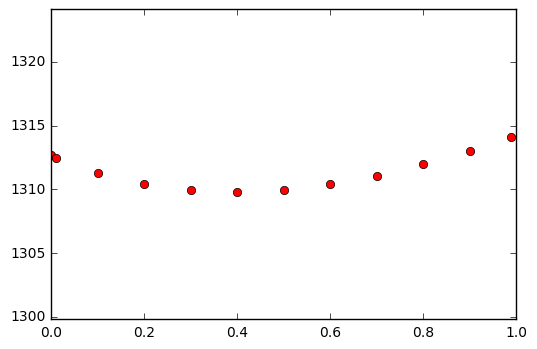

In [15]:
plt.plot(DELTA, perp, 'ro')
plt.xlim([0, 1])
print(max(perp))
plt.ylim([min(perp) - 10, max(perp) + 10])
plt.show()

А теперь для трехграмной.

In [16]:
# Try to find out best delta parameter. We will not provide you any strater code.
DELTA = [0.0001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
perp = []
for delta in DELTA:
    laplace_estomator = LaplaceProbabilityEstimator(storage, delta)
    perp.append(perplexity(laplace_estomator, test_sents))

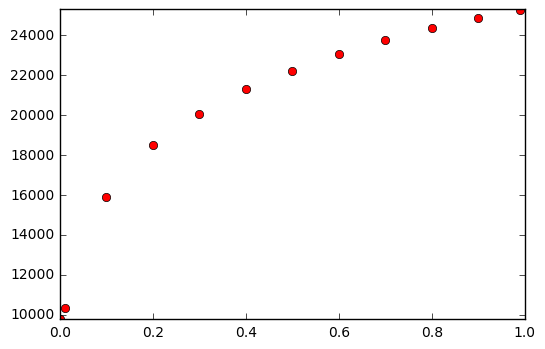

In [17]:
plt.plot(DELTA, perp, 'ro')
plt.xlim([0, 1])
plt.ylim([min(perp) - 10, max(perp) + 10])
plt.show()

Лучше получилась все еще униграмная модель с delta = 0.4. Но нас попросили посчитать с для трехграмной (вроде), так что тут дельта очень близко к нулю, посмотрим, что будет при дельта ближе к нулю.

In [18]:
# Try to find out best delta parameter. We will not provide you any strater code.
DELTA = [10 ** (-6), 10 ** (-5), 10 ** (-4), 10 ** (-3), 10 ** (-2), 10 ** (-1)]
perp = []
for delta in DELTA:
    laplace_estomator = LaplaceProbabilityEstimator(storage, delta)
    perp.append(perplexity(laplace_estomator, test_sents))

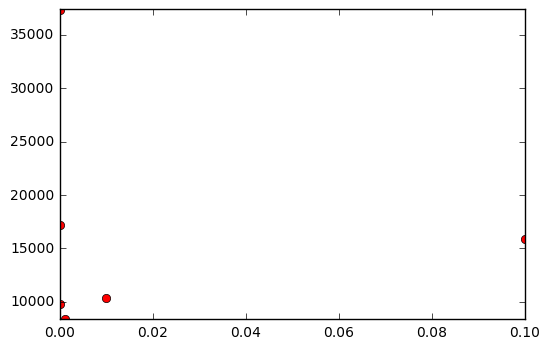

In [19]:
plt.plot(DELTA, perp, 'ro')
plt.xlim([0, 10 ** (-1)])
plt.ylim([min(perp) - 10, max(perp) + 10])
plt.show()

Для трехграмной модели лучшее дельта, которое я нашла - 10 ** (-3)

In [20]:
best_delta = 10 ** (-3)

In [21]:
# Initialize estimator
laplace_estimator = LaplaceProbabilityEstimator(storage, best_delta)

# Let's make some estimations
print('Laplace estimator perplexity = {}'.format(perplexity(laplace_estimator, test_sents)))
print(laplace_estimator.prob('To be'.split()))

Laplace estimator perplexity = 8353.75911162099
1.404562201008235e-05


## Stupid backoff

Идея **простого отката** довольно понятна. Если у нас есть достаточно информцаии для подсчета вероятности $k$-грам, то будем использовать $k$-грамы. Иначе будем использовать вероятности $(k-1)$-грам с некоторым множителем, например, $0.4$, и так далее. К сожалению, в данном случае мы получим не вероятностное распределение, но в большинстве задач это не имеет принципиального значения. Если это все же важно, то необходимо подобрать множитель соответствующим образом.

Реализуйте класс, симулирующий сглаживание простым откатом. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [22]:
class StupidBackoffProbabilityEstimator:
    """Class for stupid backoff probability estimations.
    
    P(word | context) =
        P'(word | context),                  if  P'(word | context) > 0;
        P'(word | context[1:]) * multiplier, if  P'(word | context) == 0
                                             and P'(word | context[1:]) > 0;
        ...
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        multiplier (float): Multiplier which is used for probability estimations.
    """
    
    def __init__(self, base_estimator, multiplier=0.1):
        self.__base_estimator = base_estimator
        self.__mult = multiplier
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        
        # If context is too large, let's cut it.
#         context = self.cut_context(context)
        prob = self.__base_estimator(word, context)
        mult = 1.
        while prob == 0.:
            context = context[1:]
            prob = self.__base_estimator(word, context)
            mult = mult * self.__mult
        return prob * mult
        
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [23]:
# Initialize estimator
sbackoff_estimator = StupidBackoffProbabilityEstimator(simple_estimator, .4)

# Let's make some estimations
print('Stupid backoff estimator perplexity = {}'.format(perplexity(sbackoff_estimator, test_sents)))
print(laplace_estimator.prob('To be'.split()))

Stupid backoff estimator perplexity = 154846.06426455657
1.404562201008235e-05


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Почему бессмысленно измерять перплексию в случае **Stupid backoff**?  
**A:** Ну... ее бессмысленно измерять, так как она точно будет меньше, чем у базового алгоритма, так как с помощью данного алгоритма мы по сути убираем нули...

Возможно, еще потому, что с помощью перплексии мы смотрим насколько вероятна тестовая выборка при условии нашего трейна, но в данном случае мы просто "подгоняем" нашу тестовую выборку под трейн (так как ищем конкретные нграммы, которые точно были в трейне)...


## Interpolation smoothing

В данном случае идея сглаживания посредством **интерполяции** также крайне проста. Пусть у нас есть $N$-грамная модель. Заведем вектор $\bar\lambda = (\lambda_1, \dots, \lambda_N)$, такой, что $\sum_i\lambda_i = 1$ и $\lambda_i \geq 0$. Тогда

$$
    \hat P_{IS}(w_{N} \mid w_1^{N-1}) = \sum_{i=1}^N \lambda_i \hat P_{S}(w_N \mid w_{N-i+1}^{N-1}).
$$

Придумайте, как обойтись одним вектором $\bar\lambda$, т.е. пользоваться им как в случае контекста длины $N$, так и при контексте меньшей длины (например, в начале предложения). Если мы просто обрубим сумму, то у нас уже не будет вероятностное распределение, что, конечно же, плохо.

Идея про то, как использовать тот же вектор: обрубить сумму + поделить на сумму оставшихся членов. Типа нормализовать.

In [40]:
class InterpolationProbabilityEstimator:
    """Class for interpolation probability estimations.
    
    P(word | context) =
        lambda_N * P'(word | context) +
        lambda_{N-1} * P'(word | context[1:]) +
        ... +
        lambda_1 * P'(word)
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        lambdas (np.array[float]): Lambdas which are used for probability estimations.
    """
    
    def __init__(self, base_estimator, lambdas):
        self.__lambdas = lambdas
        self.__base_estimator = base_estimator
        self.__max_n = len(lambdas)
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        context = self.cut_context(context)
        
        k = len(context) + 1
        lambdas = self.__lambdas[:k] / sum(self.__lambdas[:k])
        prob = 0.
        for i in range(k):
            prob = prob + lambdas[i] * self.__base_estimator(word, context[i:])
        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob
    
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if self.__max_n == 1:
            return ()
        if len(context) + 1 > self.__max_n:
            return context[-self.__max_n + 1:]
        return context

In [25]:
import numpy as np

# Initialize estimator
interpol_estimator = InterpolationProbabilityEstimator(simple_estimator, np.array([0.2, 0.2, 0.6]))

# Let's make some estimations
print('Interpolation estimator perplexity = {}'.format(perplexity(interpol_estimator, test_sents)))
print(laplace_estimator.prob('To be'.split()))

Interpolation estimator perplexity = 629.4520941379807
1.404562201008235e-05


Обучить значения параметров $\lambda$ можно с помощью EM-алгоритма, но мы не будем этого здесь делать.

## Kneser-Ney smoothing

Идея данного сглаживания заключается в том, что словам, которые участвуют в большом количестве контекстов, присваиваются большие вероятности, а те, которые используются в паре-тройке контекстов, получают маленькие вероятности. Формулы приведены на слайде 37 лекции.
Реализуйте данный подход.

In [82]:
class KneserNeyProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = ...
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): KneserNey parameter.
    """
    
    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        # storing the data so we don't have to calculate it often
        self.__n_plus = {}
        self.__c_sum = {}
        # first/second = ratio for initial probability
        self.__first = {}
        self.__second = self.__storage.get_different_pairs()
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if self.__storage.max_n == 1:
            return ()
        if len(context) + 1 > self.__storage.max_n:
            return context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('word must be a string!')
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        
        if len(context) == 0:
            if word in self.__first.keys():
                return 1. * self.__first[word] / self.__second
            else :
                first = 0
                diffrent_words = self.__storage.get_different_words()
                for word_1 in diffrent_words:
                    if self.__storage((word_1, word)) > 0:
                        first = first + 1
                self.__first[word] = first
                return 1. * first / self.__second
            
        c_sum = 0
        n_plus = 0
        if context in self.__c_sum.keys():
            c_sum = self.__c_sum[context]
        else:
            c_sum = self.__storage.get_c_sum(context)
            self.__c_sum[context] = c_sum
        if context in self.__n_plus.keys():
            n_plus = self.__n_plus[context]
        else:
            n_plus = self.__storage.get_n_plus(context)
            self.__n_plus[context] = n_plus
        c = self.__storage(context + (word, ))
        delta = self.__delta
        if c_sum == 0:
            return n_plus * self(word, context[1:])
        prob = max(0, c - delta) / c_sum \
            + delta / c_sum * n_plus * self(word, context[1:])
        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [83]:
# Initialize estimator
kn_estimator = KneserNeyProbabilityEstimator(storage)
# Estimating perplexity
print('Simple estimator perplexity = {}'.format(perplexity(kn_estimator, test_sents[:5])))
print(kn_estimator.prob('To be'.split()))
print(kn_estimator.prob('To be or not to be'.split()))

Simple estimator perplexity = 360081054054.8754
3.507907048560459e-06
5.914332292927681e-13


## Определение языка документа

**Постановка задачи:**  
Одна из задач, которая может быть решена при помощи языковых моделей $-$ **определение языка документа**. Реализуйте два классификатора для определения языка документа:
1. Наивный классификатор, который будет учитывать частоты символов и выбирать язык текста по признаку: распределение частот символов "наиболее похоже" на распределение частот символов в выбранном языке.
2. Классификатор на основе языковых моделей. Сами придумайте, как он должен работать.  
_Подсказка_: лучше считать n-грамы не по словам, а по символам.

---

**Как представлены данные:**  
Во всех текстовых файлах на каждой строчке записано отдельное предложение.
1. В папке _data_ находятся две папки: _full_ и _plain_. В _full_ находятся тексты в той форме, что они были взяты из сети, в _plain_ находятся те же самые тексты, но с них сначала была снята диакритика, а затем русский и греческий тексты были транслитерованы в английский.
2. В каждой из папок _full_ и _plain_ находятся папки _train_ и _test_.
3. В _train_ находятся файлы с текстами с говорящими именами, например, _ru.txt_, _en.txt_.
4. В _test_ находятся файлы _1.txt_, _2.txt_, $\dots$ в которых хранятся тексты, язык которых нужно определить. В этой же папке находится файл _ans.csv_, в котором вы можете найти правильные ответы и проверить, насколько хорошо сработали Ваши алгоритмы.

---

**Что нужно сделать:**  
Напишите два своих классификатора (которые описаны в постановке задачи) и получите максимально возможное accuracy на test-сете. Разрешается использовать только _train_ для обучения.

---

**В данном задании мы не предоставляем стартового кода!**

В первом решении просто каждому языку сопоставляем частоты символов, а потом для каждого нового текста сравниваем частоту для него и частоты всех языков с помощью mse.

In [29]:
class NaiveClassifier:
    def __init__(self):
        # chars frequences
        self.__matcher = {}
        self.__max_char = 1114112
    
    def add(self, words, lang):
        chars = [0 for _ in range(self.__max_char)]
        chars_number = 0
        for word in words:
            for char in word:
                chars[ord(char)] = chars[ord(char)] + 1
                chars_number = chars_number + 1
        for i in range(self.__max_char):
            chars[i] = chars[i] / chars_number
        self.__matcher[lang] = np.array(chars)
    
    def evaluate(self, sents):
        chars = [0 for _ in range(self.__max_char)]
        chars_number = 0
        for word in words:
            for char in word:
                chars[ord(char)] = chars[ord(char)] + 1
                chars_number = chars_number + 1
        for i in range(self.__max_char):
            chars[i] = chars[i] / chars_number
        min_mse = 10000000
        chars = np.array(chars)
        final_lang = ""
        for lang in self.__matcher.keys():
            mse = ((chars - self.__matcher[lang]) ** 2).mean()
            if mse < min_mse:
                min_mse = mse
                final_lang = lang
        return final_lang

In [2]:
import os
import re
import numpy as np
import pandas as pd

In [3]:
naive_classifier = NaiveClassifier()

Train

Сопостовляем языкам частоты символов.

In [4]:
for filename in os.listdir("full/train/"):
    if filename.endswith(".txt"): 
        file = open("full/train/" + filename, 'r')
        lang = filename[:-4]
        words = re.split('(\W+)', file.read()) 
        # there is empty file eo.txt
        if len(words) != 1:
            naive_classifier.add(words, lang)

Test

Сравниваем полученные для данного файла частоты с частотами для языков.

In [5]:
answer = {}
for filename in os.listdir("full/test/"):
    if filename.endswith(".txt"): 
        file = open("full/test/" + filename, 'r')
        words = re.split('(\W+)', file.read()) 
        lang = naive_classifier.evaluate(words)
        answer[filename[:-4]] = lang

Retrieving answer

In [14]:
data = pd.read_csv("full/test/ans.csv", header=None)
real_answer = {}
for i in range(data[0].size):
    real_answer[str(i + 1)] = data[1][i]

In [15]:
correct_answers = 0
for i in range(data[0].size):
    if real_answer[str(i + 1)] == answer[str(i + 1)]:
        correct_answers = correct_answers + 1
print("Accuracy:", correct_answers / data[0].size)

Accuracy: 0.9375


Not that bad.

Теперь давайте о языковой модели. Как было упомянуто на лекции надо взять аргмакс по языку p(text|lang). То есть это значит, что для каждого языка мы можем построить его языковую модель, а потом на тесте посчитать вероятность тестового текста.

Причем будем оценивать весь текст целиком. Так как он является нашей единицей измерения. И использовать интерполяционное сглаживание + трехграмной моделью.

In [84]:
class NgramClassifier:
    def __init__(self):
        # smoothing
        self.__matcher = {}
    
    def add(self, text, lang):
        storage = NGramStorage([list(text)], 3)
        simple_estimator = StraightforwardProbabilityEstimator(
            storage)
        self.__matcher[lang] = InterpolationProbabilityEstimator(
            simple_estimator, np.array([0.2, 0.2, 0.6]))
        print("Estimator for", lang, "is ready")
    
    def evaluate(self, text):
        final_lang = ""
        max_prob = 0.
        for lang in self.__matcher.keys():
            prob = self.__matcher[lang].prob(list(text))
            if prob > max_prob:
                max_prob = prob
                final_lang = lang
        return final_lang

In [85]:
ngram_classifier = NgramClassifier()

Train

Создаем сглаживания для каждого языка по всему тексту.

In [86]:
for filename in os.listdir("full/train/"):
    if filename.endswith(".txt"): 
        file = open("full/train/" + filename, 'r')
        lang = filename[:-4]
        # there is empty file eo.txt
        text = file.read()
        if len(text) != 0:
            ngram_classifier.add(text, lang)

Estimator for fr is ready
Estimator for fi is ready
Estimator for pt is ready
Estimator for ca is ready
Estimator for nl is ready
Estimator for it is ready
Estimator for hu is ready
Estimator for es is ready
Estimator for en is ready
Estimator for ru is ready
Estimator for pl is ready
Estimator for sv is ready
Estimator for el is ready
Estimator for de is ready
Estimator for no is ready


Test

Оцениваем вероятность того, что какой-то текст принадлежит конкретному языку (то есть по сути просто вероятность того, что он сгенерирован из соответствующего теста).

In [87]:
answer = {}
for filename in os.listdir("full/test/"):
    if filename.endswith(".txt"): 
        file = open("full/test/" + filename, 'r')
        lang = ngram_classifier.evaluate(file.read())
        answer[filename[:-4]] = lang

In [88]:
correct_answers = 0
for i in range(data[0].size):
    if real_answer[str(i + 1)] == answer[str(i + 1)]:
        correct_answers = correct_answers + 1
print("Accuracy:", correct_answers / data[0].size)

Accuracy: 0.008333333333333333


Опять исполняется долго, но, код не ботает и не тормозит совсем. Если будет возможность выписать что он в итоге вернул после, то я сделаю это.